In [3]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from numpy.random import seed
from keras.layers import Input, Dropout,Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
from scipy.special import softmax

# Context
##### This dataset contains the machine data of a degrading component recorded over the duration of 12 month total. It was initiated in the European research and innovation project IMPROVE.

# Content
###### The Vega shrink-wrapper from OCME is deployed in large production lines in the food and beverage industry. The machine groups loose bottles or cans into set package sizes, wraps them in plastic film and then heat-shrinks the plastic film to combine them into a package. The plastic film is fed into the machine from large spools and is then cut to the length needed to wrap the film around a pack of goods. The cutting assembly is an important component of the machine to meet the high availability target. Therefore, the blade needs to be set-up and maintained properly. Furthermore, the blade can not be inspected visually during operation due to the blade being enclosed in a metal housing and its fast rotation speed. Monitoring the cutting blades degradation will increase the machines reliability and reduce unexpected downtime caused by failed cuts.



#### The 519 files in the dataset are of the format MM-DDTHHMMSS_NUM_modeX.csv, where MM is the month ranging from 1-12 (not calendar month), DD is the day of the month, HHMMSS is the start time of day of recording, NUM is the sample number and X is a mode ranging from 1-8. Each file is a ~8 second sample with a time resolution of 4ms that totals 2048 time-samples for every file.

#  DATA

### --pCut::Motor_Torque -> Torque in nM

### --pCut::CTRL_Position_controller::Lag_error -> Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor

### --pCut::CTRL_Position_controller::Actual_position -> Cutting blade position in mm

### --pCut::CTRL_Position_controller::Actual_speed -> Speed of the cutting blade

### --pSvolFilm::CTRL_Position_controller::Actual_position -> Plastic film unwinder position in mm

### --pSvolFilm::CTRL_Position_controller::Actual_speed -> Speed of the plastic film unwinder

### --pSvolFilm::CTRL_Position_controller::Lag_error -> Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor

### --pSpintor::VAX_speed -> VAX measurement of performance


**First things first, we have info on the samples that aren't in our sample csv files. Also, all our samples are separated in different files. So I compiled it all together to get a big dataframe with everything we need as the One_year_compiled.csv.**

In [ ]:
main_df = pd.read_csv('/content/One_year_compiled.csv')
main_df.describe()

,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed,month,day,hour,sample_Number
count,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06
mean,4.102069e+00,-1.206338e-01,-5.472746e-05,3.371415e+08,1.945795e+03,1.488169e+08,5.367032e+03,9.847591e-01,1.927328e+03,5.268391e+00,1.653583e+01,1.361880e+05,2.588735e+02
std,2.364827e+00,6.078708e-01,1.212122e-01,5.466868e+08,4.873922e+03,2.711355e+08,3.382194e+03,3.437204e-01,6.559047e+02,3.502912e+00,8.488445e+00,3.225299e+04,1.497494e+02
min,4.000000e-03,-6.560303e+00,-1.888258e+00,-2.039056e+09,-9.482574e+03,1.936250e+05,-2.013385e+01,-9.143658e-01,0.000000e+00,1.000000e+00,1.000000e+00,8.115800e+04,0.000000e+00
25%,2.056000e+00,-3.696310e-01,-2.201461e-02,8.626082e+07,-1.908875e+03,2.136702e+07,3.032669e+03,8.384416e-01,1.500000e+03,2.000000e+00,9.000000e+00,1.113170e+05,1.290000e+02
50%,4.104000e+00,-1.187128e-01,6.456900e-04,1.919407e+08,2.595520e+03,7.259557e+07,4.582979e+03,9.711797e-01,1.800000e+03,4.000000e+00,1.800000e+01,1.348180e+05,2.590000e+02
75%,6.152000e+00,2.546913e-01,2.380830e-02,5.691639e+08,5.441666e+03,1.602507e+08,5.823731e+03,1.105926e+00,2.280000e+03,8.000000e+00,2.300000e+01,1.618270e+05,3.890000e+02
max,8.199999e+00,3.856873e+00,2.021531e+00,1.911789e+09,1.792831e+04,1.453671e+09,1.797202e+04,3.567880e+00,3.600000e+03,1.200000e+01,3.100000e+01,2.232490e+05,5.180000e+02


**Let's look for correlation between data. As you will see, the only things that look correlated is the Motor Torque, Blade Speed and the Blade Lag Error, also the VAX speed and wrapper speed. Excluding of course, month and sample_number, and all self correlations on the diagonal.**

<Axes: >

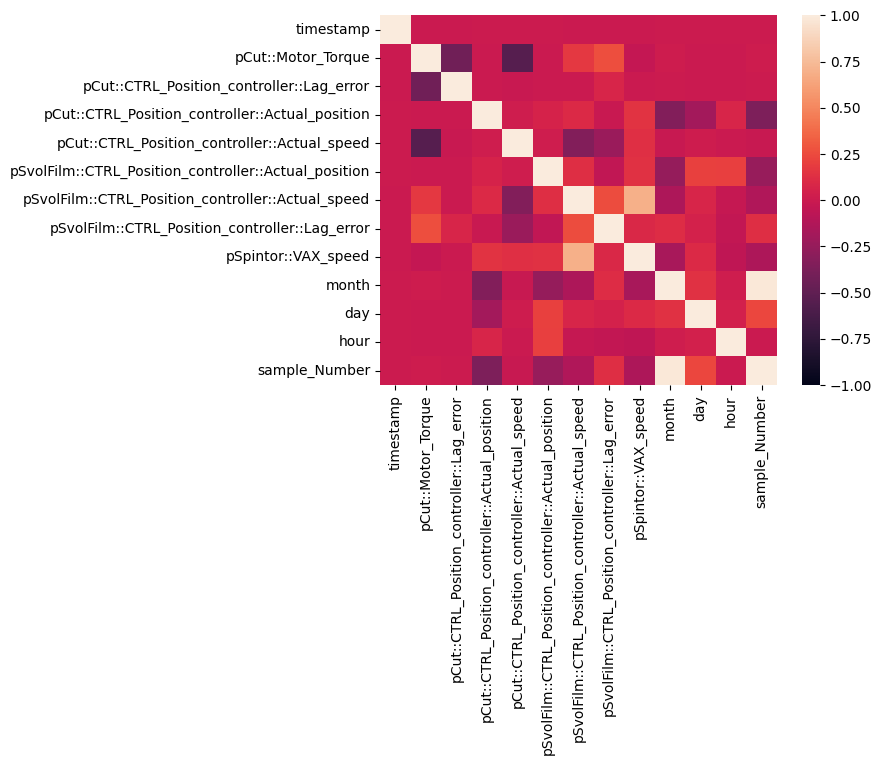

In [ ]:
#heatmap of correlations from -1 to 1
#Drop the 'mode' column which contains strings,
# before calculating the correlation matrix.
sns.heatmap(main_df.drop(columns=['mode']).corr(), vmin= -1, vmax = 1)

**Lets drop some columns and flip our motor torque column values by multiplying it by -1. Just for some more visual understanding**

<Axes: >

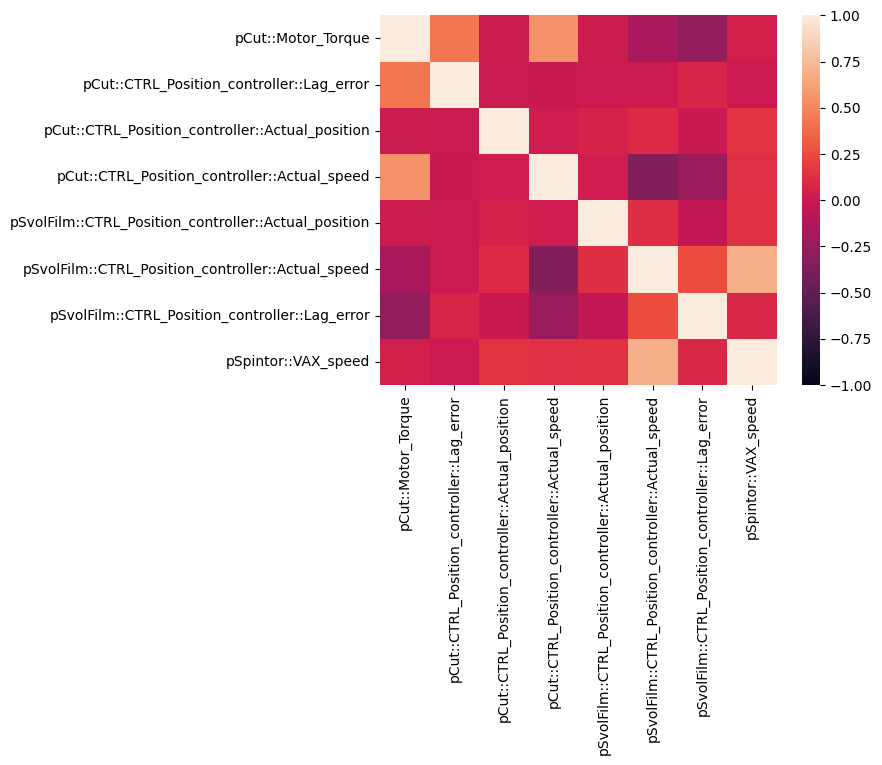

In [ ]:
main_df = pd.read_csv('/content/One_year_compiled.csv')
#Dropping nonsense columns for this proposal                                 (axis=1) = columns
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
#Flipping column values
main_df['pCut::Motor_Torque'] = main_df['pCut::Motor_Torque'] *-1
#Heatmap
sns.heatmap(main_df.drop(columns=['mode']).corr(), vmin= -1, vmax = 1)


## Treating non-numerical data

**In our dataset, the modes for the machine may influence in data patterns, so we need to transform that data from string to numerical classes. This function will do just that.**

In [4]:
def handle_non_numeric(df):
    # Values in each column for each column
    columns = df.columns.values

    for column in columns:

        # Dictionary with each numerical value for each text
        text_digit_vals = {}

        # Receives text to convert to a number
        def convert_to_int (val):

            # Returns respective numerical value for class
            return text_digit_vals[val]

        # If values in columns are not float or int
        if df[column].dtype !=np.int64 and df[column].dtype != np.float64:

            # Gets values form current column
            column_contents = df[column].values.tolist()

            # Gets unique values from current column
            unique_elements = set(column_contents)

            # Classification starts at 0
            x=0

            for unique in unique_elements:

                # Adds the class value for the text in dictionary, if it's not there
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            # Maps the numerical values to the text values in columns
            df[column] = list(map(convert_to_int, df[column]))

    return df

# Approach

**A few algorithms will be tested to see if we can get some info on the machine. We will use OneClass SVM and KMeans with 1 cluster to try clustering. After that we will try an Autoencoder to try and reproduce data based on the machines healthy condition.**

**In all 3 cases we will grab a slice of the first rows and consider it as the Healthy State of the machine, then feed it to the algorithms. After that we will give the algorithms the entirety of the dataset and see how they perform on the rest of the data. Deviations, low scores, and high losses will be considered as anomalies to be studied.**

# OneClass SVM approach

**OneClass SVM is used for outlier detection, it tries to find 2 classes in the data, the "normal" class and the outliers. We will use the SVM to try and find outliers and anomalies.**

In [ ]:
#Grabbing the entire dataset
main_df = pd.read_csv('/content/One_year_compiled.csv')
#Dropping columns with unwanted/irrelevant info for the algorithm
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
#Transforming modes into classified data
main_df = handle_non_numeric(main_df)

#Passing our dataframe as our features
X = main_df

#Defining preprocessor for the data
scaler = preprocessing.MinMaxScaler()
#Preprocessing
X = pd.DataFrame(scaler.fit_transform(X),
                              columns=X.columns,
                              index=X.index)


#Scaling
X = preprocessing.scale(X)
#Splitting the feature data for training data. First 200.000 rows.
X_train = X[:200000]


#Creating a fitting OneClass SVM
ocsvm = OneClassSVM(nu=0.25, gamma=0.05)
ocsvm.fit(X_train)

OneClassSVM(gamma=0.05, nu=0.25)

**Predicting and classifying the dataset in anomalies and non-anomalies, then passing it to a dataframe.**

In [1]:


df=main_df.copy()
df['anomaly'] = pd.Series(ocsvm.predict(X))



NameError: name 'main_df' is not defined

**Saving Dataframe**

In [ ]:
#Saving Dataframe.
df.to_csv('Labled_df.csv')

**Reading into dataframe**

In [ ]:
#Reading into dataframe
df = pd.read_csv('../input/created/Labled_df.csv', index_col=0)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/created/Labled_df.csv'

**Visualizing anomalies**

In [ ]:
#Getting labled groups
scat_1 = df.groupby('anomaly').get_group(1)
scat_0 = df.groupby('anomaly').get_group(-1)

# Plot size
plt.subplots(figsize=(15,7))

# Plot group 1 -labeled, color green, point size 1
plt.plot(scat_1.index,scat_1['pCut::Motor_Torque'], 'g.', markersize=1)

# Plot group -1 -labeled, color red, point size 1
plt.plot(scat_0.index, scat_0['pCut::Motor_Torque'],'r.', markersize=1)


**Visualizing scores for the whole dataset**

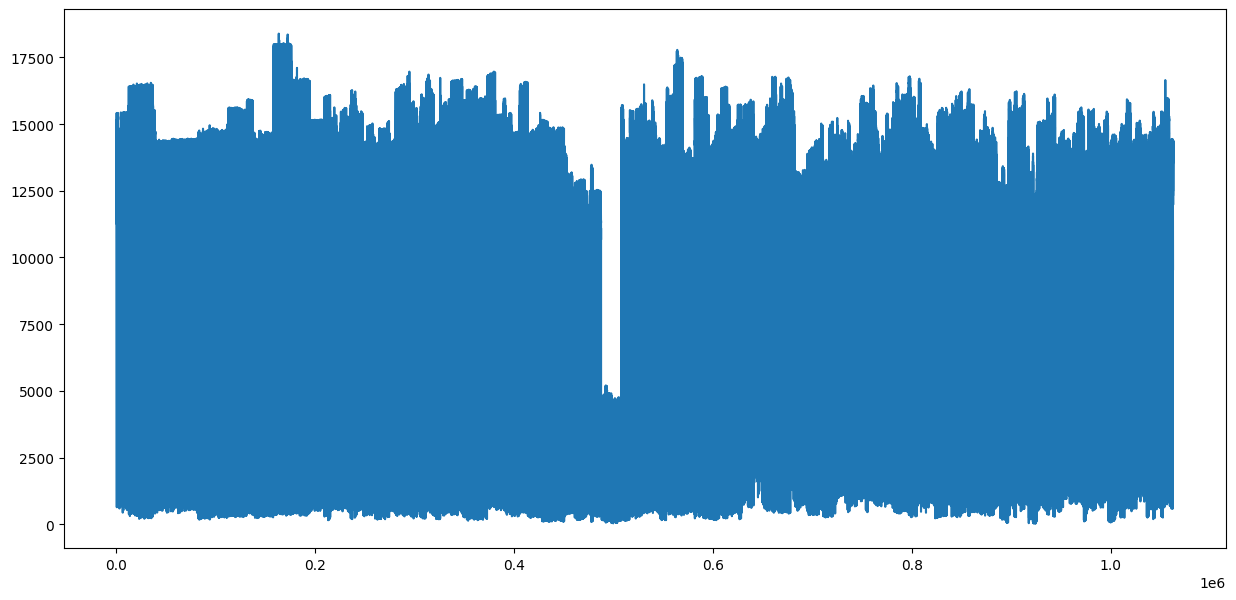

In [ ]:
#Creating a dataframe for the score of each data sample
score = pd.DataFrame()
#Returning scores for the dataset
score['score'] = ocsvm.score_samples(X)

#Plot size
plt.subplots(figsize=(15,7))
#Plotting
score['score'].plot()
#Saving score dataframe
score.to_csv('SVM_Score.csv')

**Inverted score moving mean**

<Axes: >

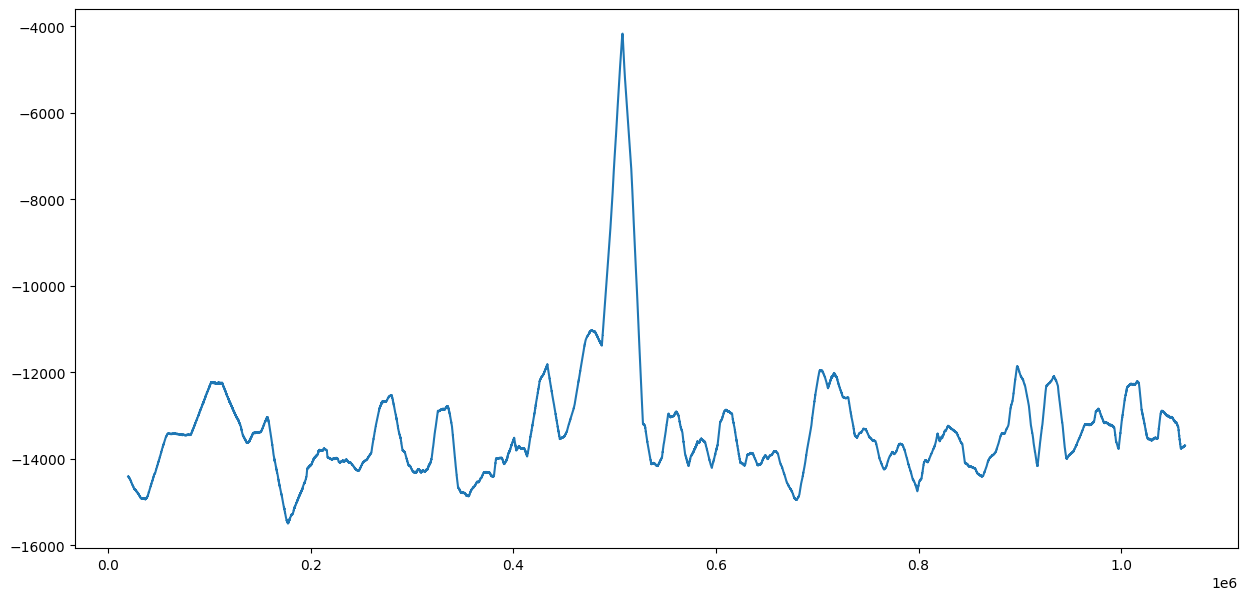

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))


((score['score'].rolling(20000).mean())*-1).plot(ax=ax)

**Scat plot to see the score through the noise**

In [ ]:
plt.subplots(figsize=(15,7))
plt.plot(score.index, score['score'],'r.', markersize=1)

# AutoEncoder approach

**AutoEncodersare Neural nets that expandes and compresses data into higher and lower dimensions, then tries to recreate the data. The idea is that the autoencoder will understand the relation between the features and from that, it will recreate the exact data it was given.**

**We will feed the algorithm the healthy state of the machine. As it tries to rebuild the rest of the data as the healthy state, reconstruction loss, difference between predicted machine data and real machine data, will be considered "unhealthy" state.**

In [5]:
#------------------------- Preparing data for training ---------------------------
main_df = pd.read_csv('/content/One_year_compiled.csv')
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X),
                              columns=X.columns,
                              index=X.index)



X = preprocessing.scale(X)


train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)

X_train = X[:train_size]
#----------------------------------------------------------------------------------



#Seed for random batch validation and training
seed(10)


#Elu activatoin function
act_func = 'elu'

# Input layer
model=Sequential()

# First hidden layer, connected to input vector X.
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )
# Second hidden layer
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))
# Thrid hidden layer
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform'))

# Input layer
model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

# Loss function and Optimizer choice
model.compile(loss='mse',optimizer='adam')

# Train model for 50 epochs, batch size of 200
NUM_EPOCHS=50
BATCH_SIZE=200

#Grabbing validation and training loss over epochs
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE,
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1873 - val_loss: 0.1304
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0120 - val_loss: 0.1014
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0999
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0959
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4626e-04 - val_loss: 0.0928
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1304e-04 - val_loss: 0.0907
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5283e-04 - val_loss: 0.0889
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.5716e-04 - val_loss: 0.0879
Epoch 9/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8969e-04 - val_loss: 0.0875
Epoch 10/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4153e-04 - val_loss: 0.0864
Epoch 11/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0719e-04 - val_loss: 0.0868
Epoch 12/50
194/194 ━━━━

**Plotting Validation loss and Training loss over the epochs**

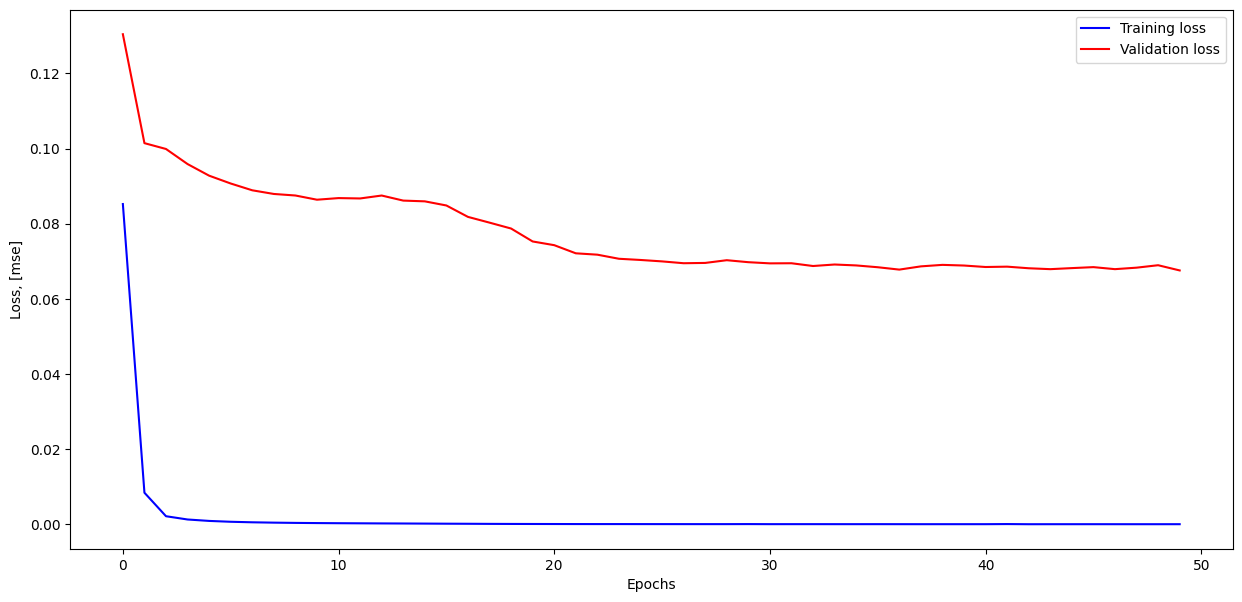

In [6]:
plt.subplots(figsize=(15,7))

plt.plot(history.history['loss'],'b',label='Training loss')
plt.plot(history.history['val_loss'],'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')

plt.show()

**Now we will feed the algortihm the same training data, and make it try to reconstruct data. We will then see the distribution of the loss over the train data, further on we will use this distribution to determine some Thresholds.**

1343/1343 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<ipython-input-7-f9b3c2d9ae21>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'],


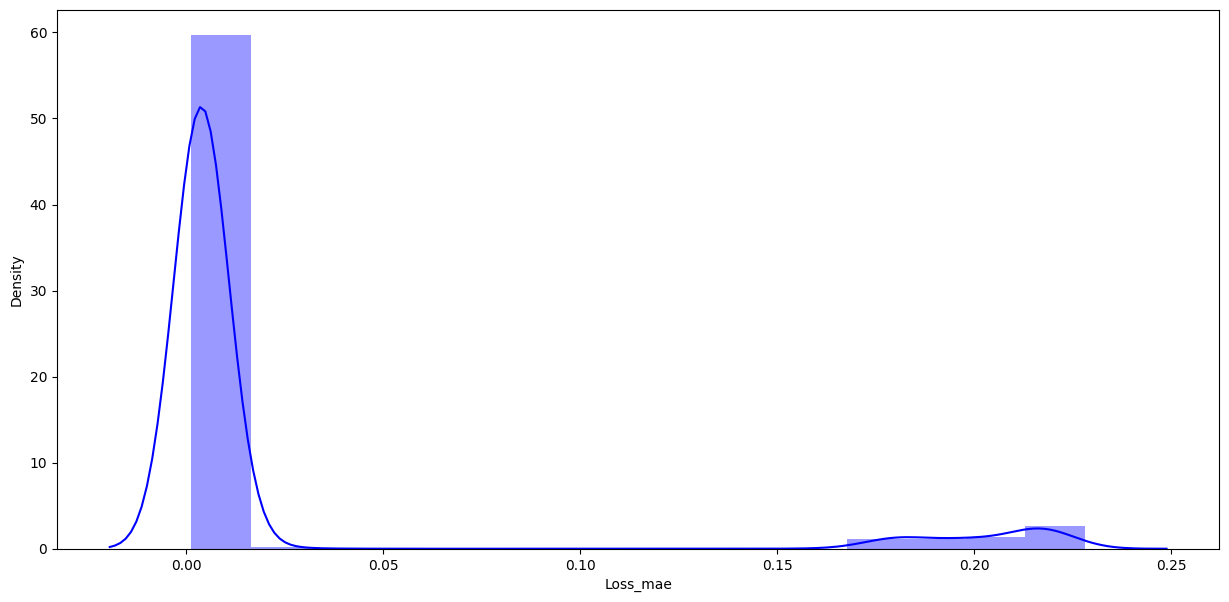

In [7]:
#Reconstructing train data
X_pred = model.predict(np.array(X_train))

#Creating dataframe for reconstructed data
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X_train).index

#Dataframe to get the difference of predicted data and real data.
scored = pd.DataFrame(index=pd.DataFrame(X_train).index)
#Returning the mean of the loss for each column
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

#plot
plt.subplots(figsize=(15,7))
sns.distplot(scored['Loss_mae'],
             bins = 15,
             kde= True,
            color = 'blue');





8952/8952 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


Text(0, 0.5, 'Loss, [mse]')

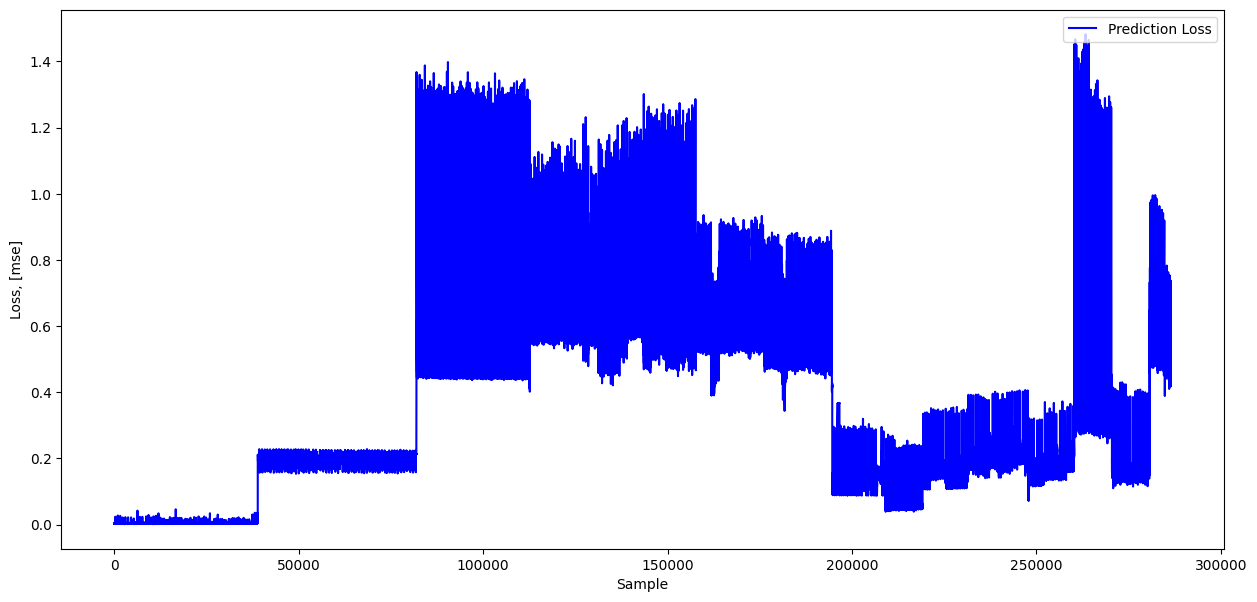

In [8]:

#Reconstructing full data
X_pred = model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X).index

#Returning mean of the losses for each column and putting it in a dataframe
scored = pd.DataFrame(index=pd.DataFrame(X).index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

#Plot size
plt.subplots(figsize=(15,7))


#Saving dataframe
scored.to_csv('AutoEncoder_loss.csv')

#Plot
plt.plot(scored['Loss_mae'],'b',label='Prediction Loss')

plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Loss, [mse]')

# Results Analysis

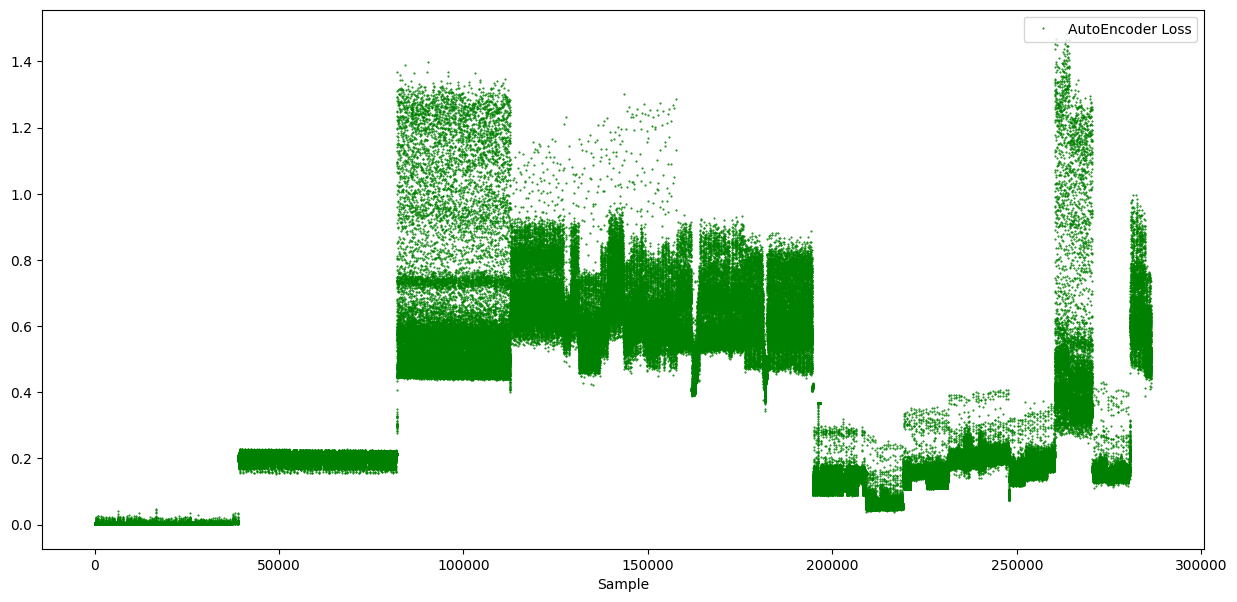

In [10]:
#Plot size
plt.subplots(figsize=(15,7))
#Reading loss csv file
enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')
#Plot
plt.plot(enc_loss.index,enc_loss['Loss_mae'], 'g.', markersize=1,label="AutoEncoder Loss")
#Labels and legends
plt.legend(loc='upper right')
plt.xlabel('Sample')
#Show plot
plt.show()

**Plotting each algorithm scoring together, with OCSVM flipped over 0.**

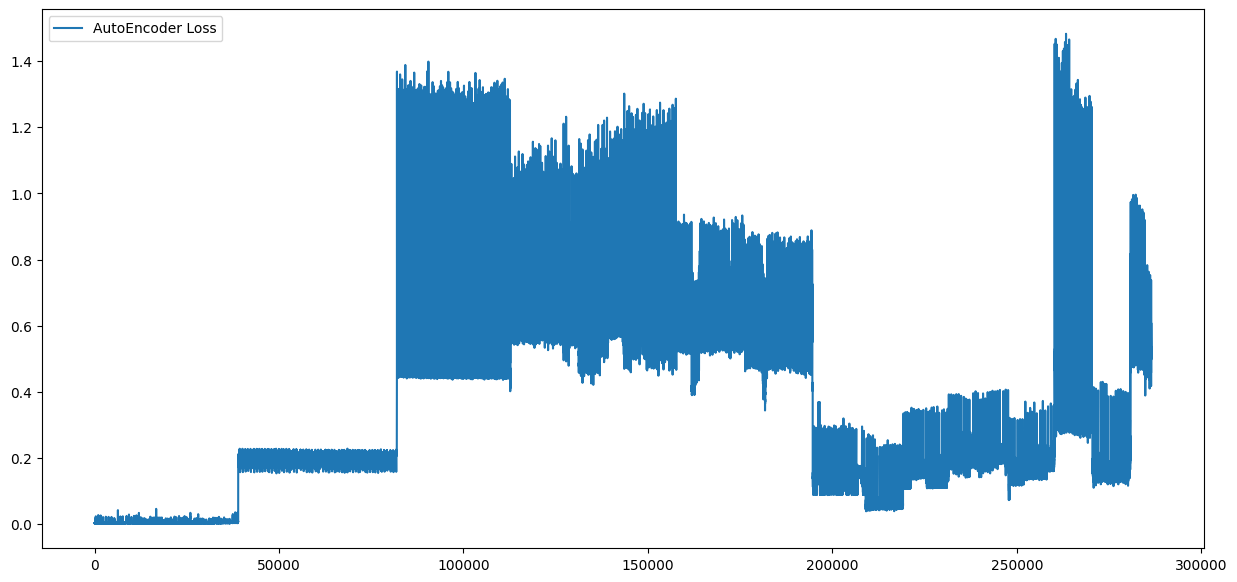

In [13]:
#Plot size
plt.subplots(figsize=(15,7))

enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')


plt.plot(enc_loss.index,enc_loss['Loss_mae'], label="AutoEncoder Loss")



plt.gca().legend(('AutoEncoder Loss','OCSVM score * -1','Kmeans Euclidean Dist'))


**Looking for correlation between the algorithms**

In [15]:

enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

# Dataframe to see correlation
corr = pd.DataFrame()

corr['AutoEnc_loss'] = enc_loss['Loss_mae']

#Seeing correlation
corr.corr()

,AutoEnc_loss
AutoEnc_loss,1.0


**Scatter plot with movving mean**

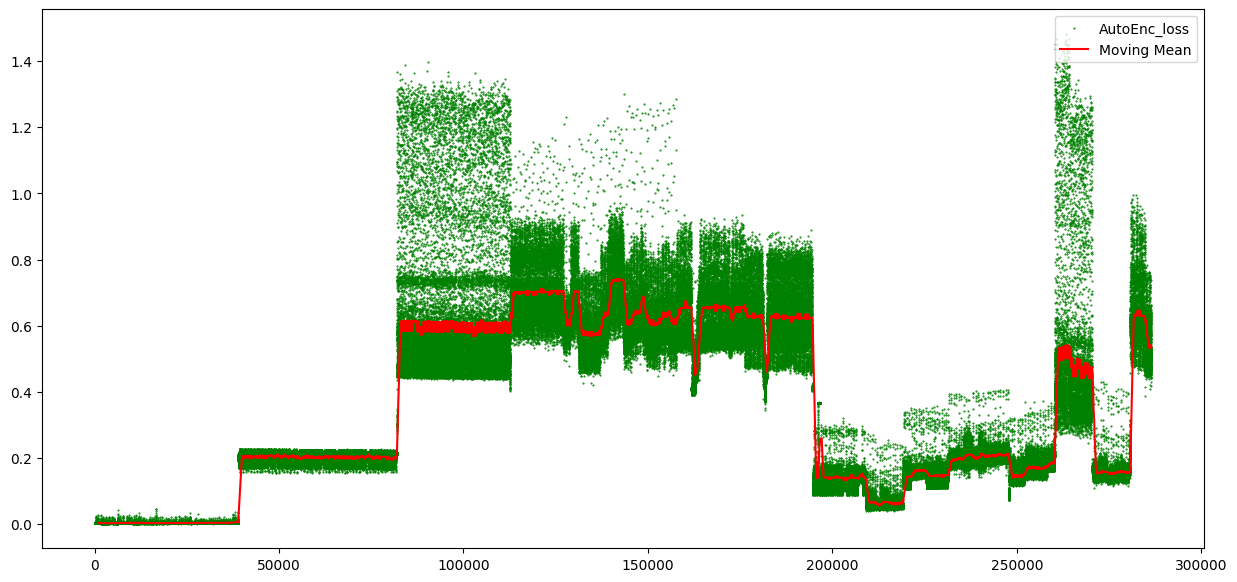

In [18]:

enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

corr = pd.DataFrame()

corr['AutoEnc_loss'] = enc_loss['Loss_mae']





plt.subplots(figsize=(15,7))

plt.plot(corr.index, corr['AutoEnc_loss'], 'g.', markersize=1, label = 'AutoEnc_loss')
plt.plot(corr.index, corr['AutoEnc_loss'].rolling(1000).mean(), 'r', markersize=1, label = 'Moving Mean')


plt.legend(loc='upper right')
plt.show()



**Loss Distribution over training data**

<ipython-input-21-ab68965d032e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(corr['AutoEnc_loss'].head(160000),bins=15)


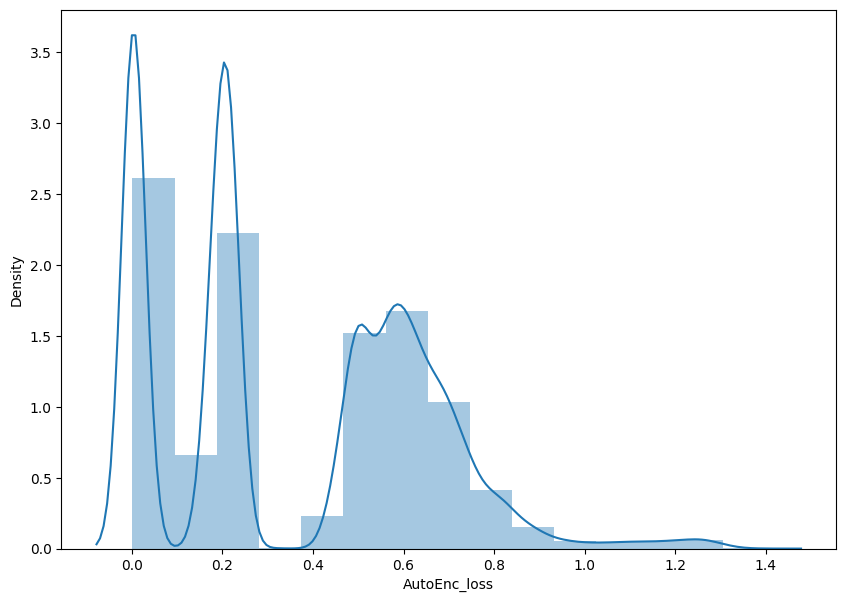

In [21]:
enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['AutoEnc_loss'] = enc_loss['Loss_mae']





plt.subplots(figsize=(10,7))
sns.distplot(corr['AutoEnc_loss'].head(160000),bins=15)
plt.show()

**Loss distribution over entire dataset**

<ipython-input-23-14f47b69ff84>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(corr['AutoEnc_loss'],bins=15)


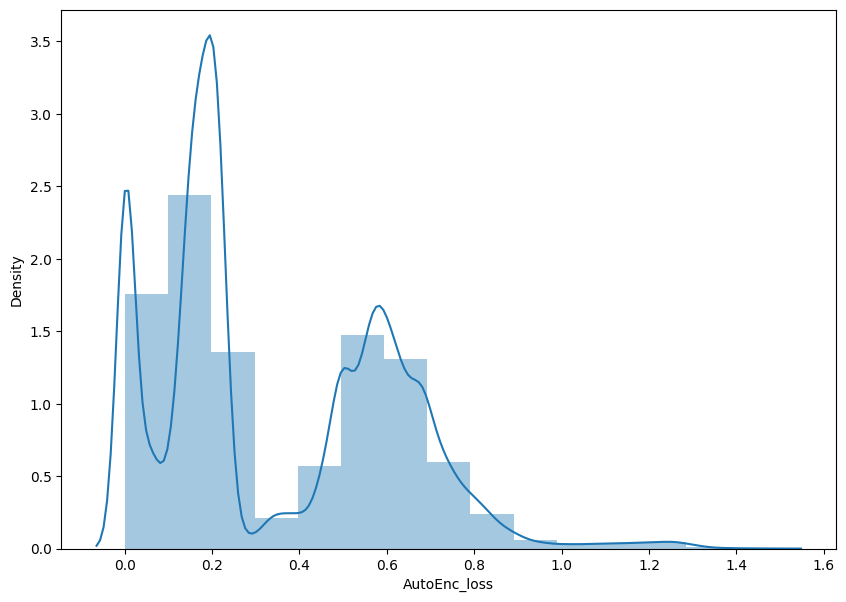

In [23]:
enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['AutoEnc_loss'] = enc_loss['Loss_mae']






plt.subplots(figsize=(10,7))
sns.distplot(corr['AutoEnc_loss'],bins=15)
plt.show()

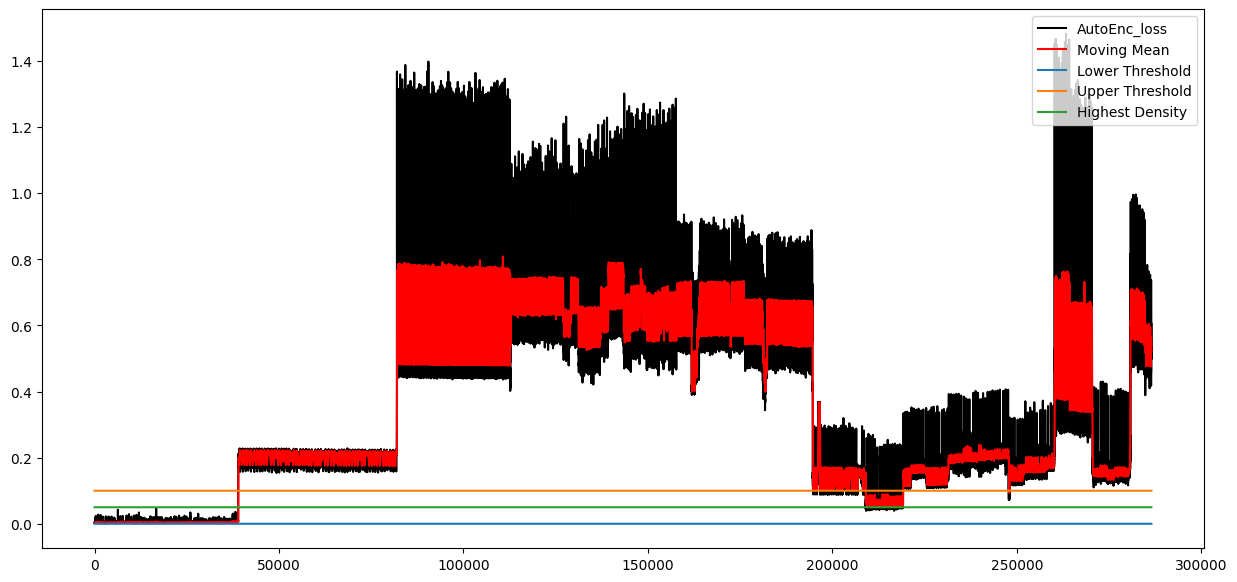

In [26]:

enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

corr = pd.DataFrame()

corr['AutoEnc_loss'] = enc_loss['Loss_mae']


lower_threshold = np.full((corr['AutoEnc_loss'].size, 1), 0)
upper_threshold = np.full((corr['AutoEnc_loss'].size, 1), 0.1)
high_density_threshold = np.full((corr['AutoEnc_loss'].size, 1), 0.05)

plt.subplots(figsize=(15,7))

plt.plot(corr.index, corr['AutoEnc_loss'], 'k', markersize=1, label = 'AutoEnc_loss')
plt.plot(corr.index, corr['AutoEnc_loss'].rolling(100).mean(), 'r', markersize=1, label = 'Moving Mean')
plt.plot(corr.index, lower_threshold, label='Lower Threshold')
plt.plot(corr.index, upper_threshold, label = 'Upper Threshold')
plt.plot(corr.index, high_density_threshold, label = 'Highest Density')
plt.legend(loc='upper right')
plt.show()


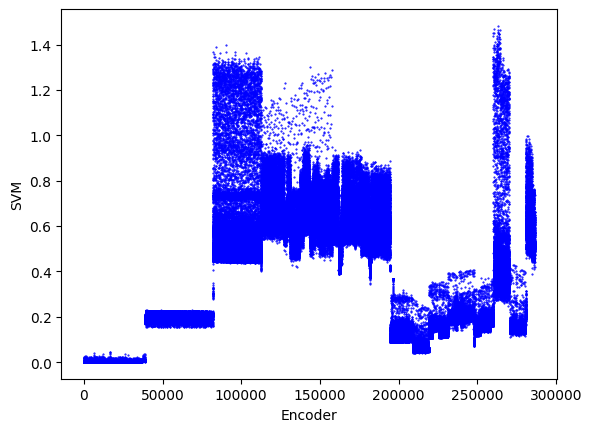

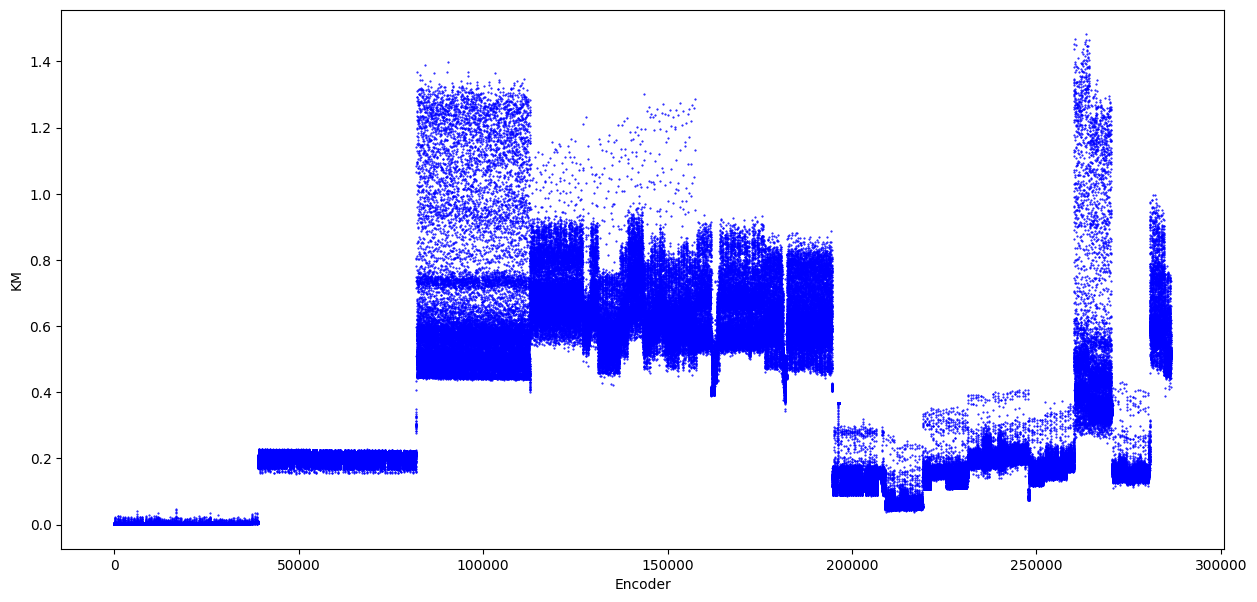

In [35]:
enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['AutoEnc_loss'] = enc_loss['Loss_mae']


plt.plot(corr['AutoEnc_loss'],'b.' ,markersize=1 )
plt.xlabel('Encoder')
plt.ylabel('SVM')
plt.show()

plt.subplots(figsize=(15,7))

plt.plot(corr['AutoEnc_loss'],'b.' ,markersize=1 )
plt.xlabel('Encoder')
plt.ylabel('KM')
plt.show()

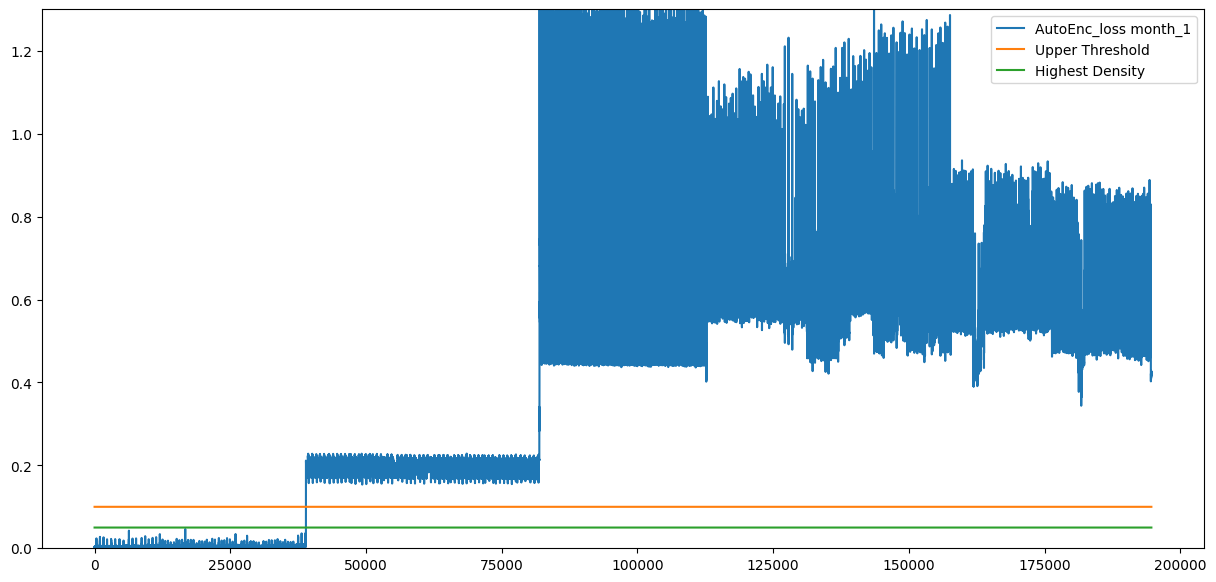

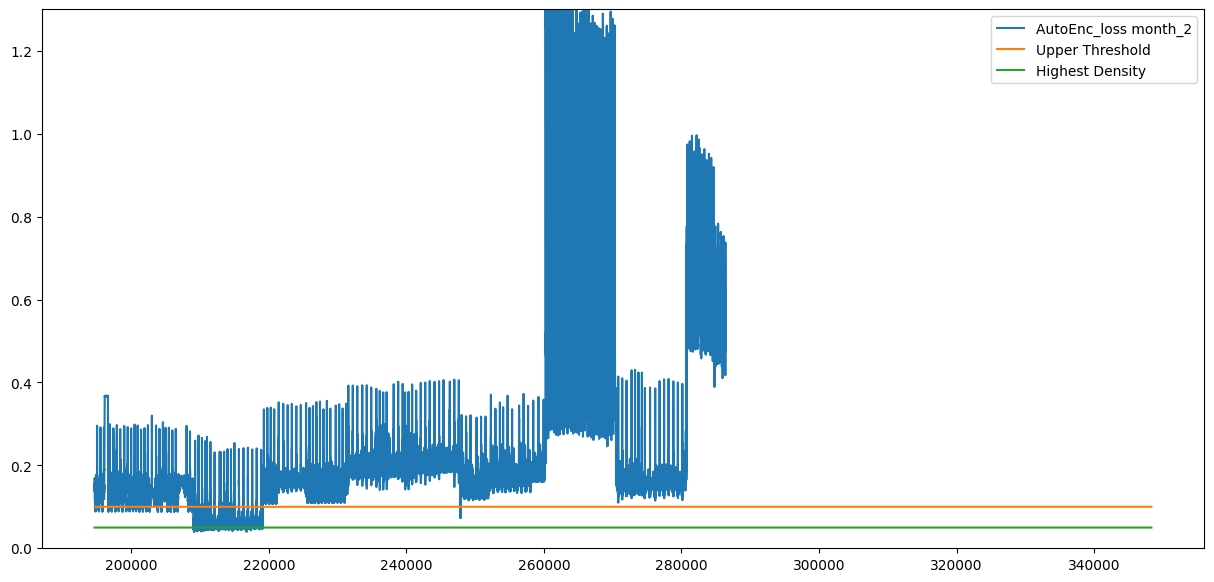

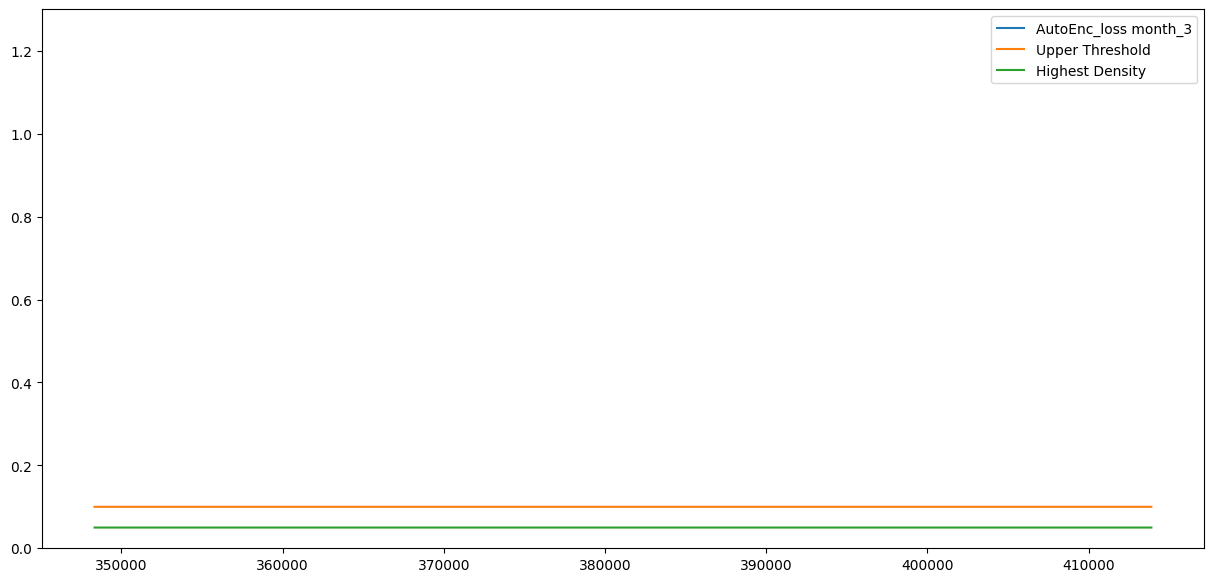

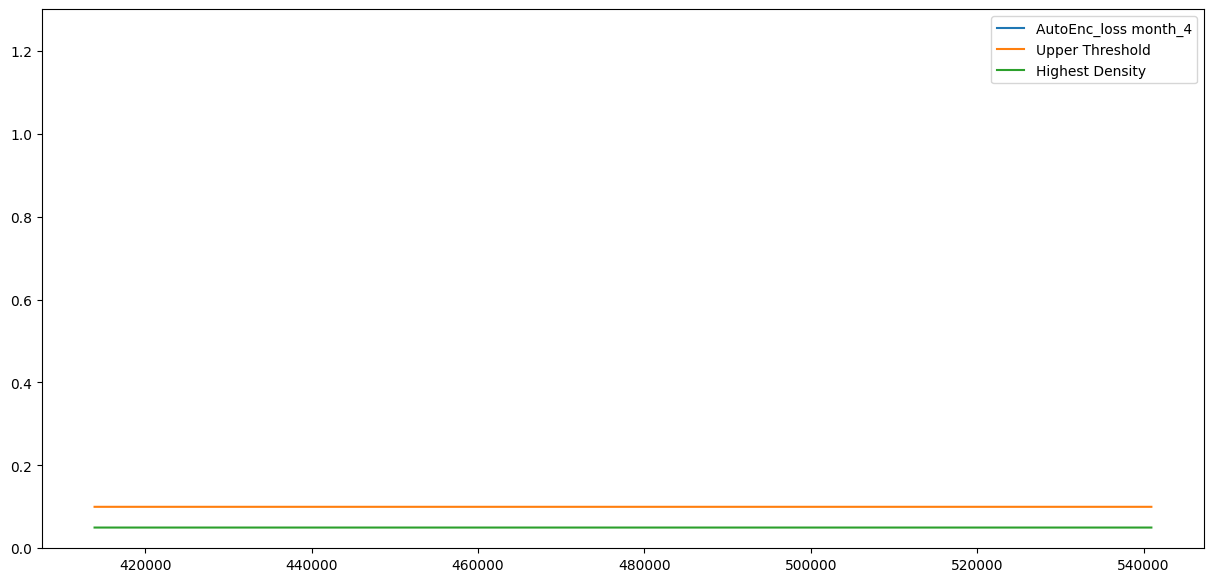

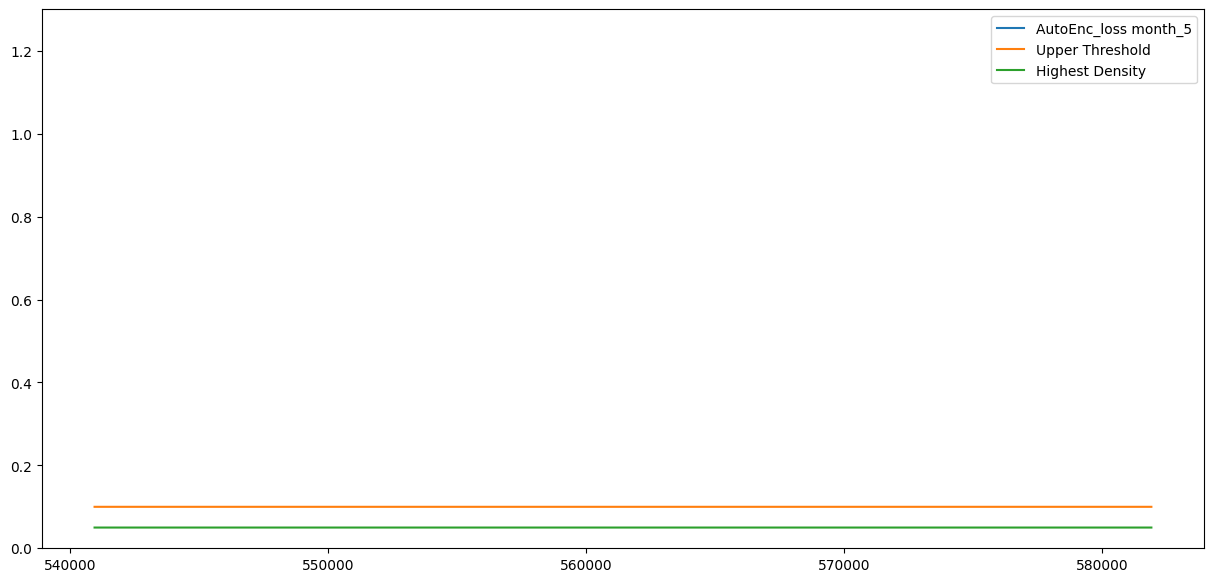

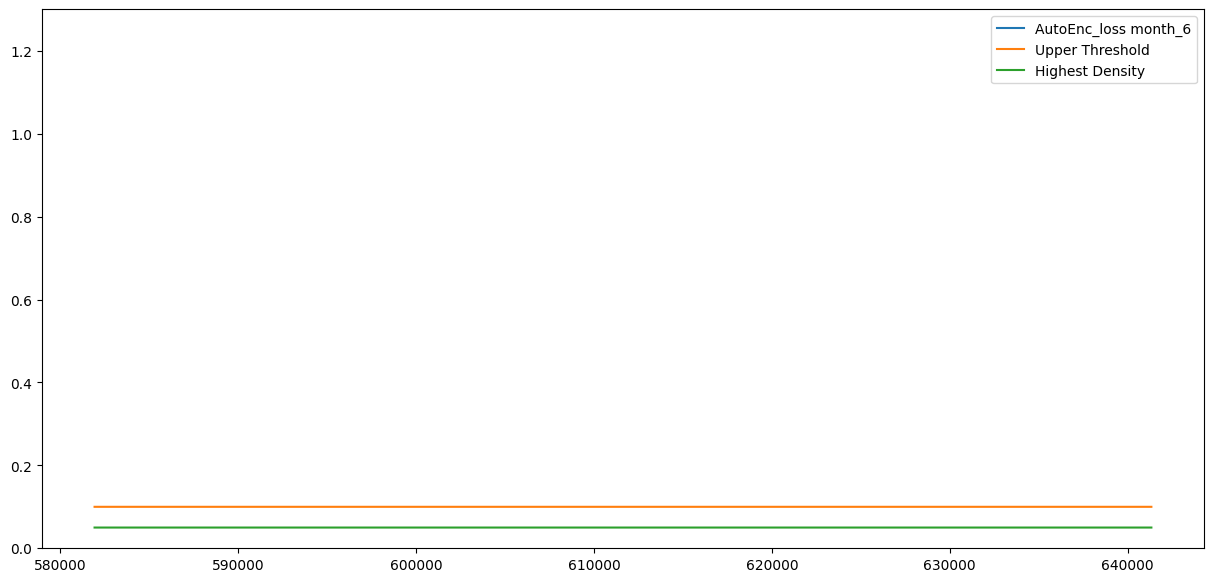

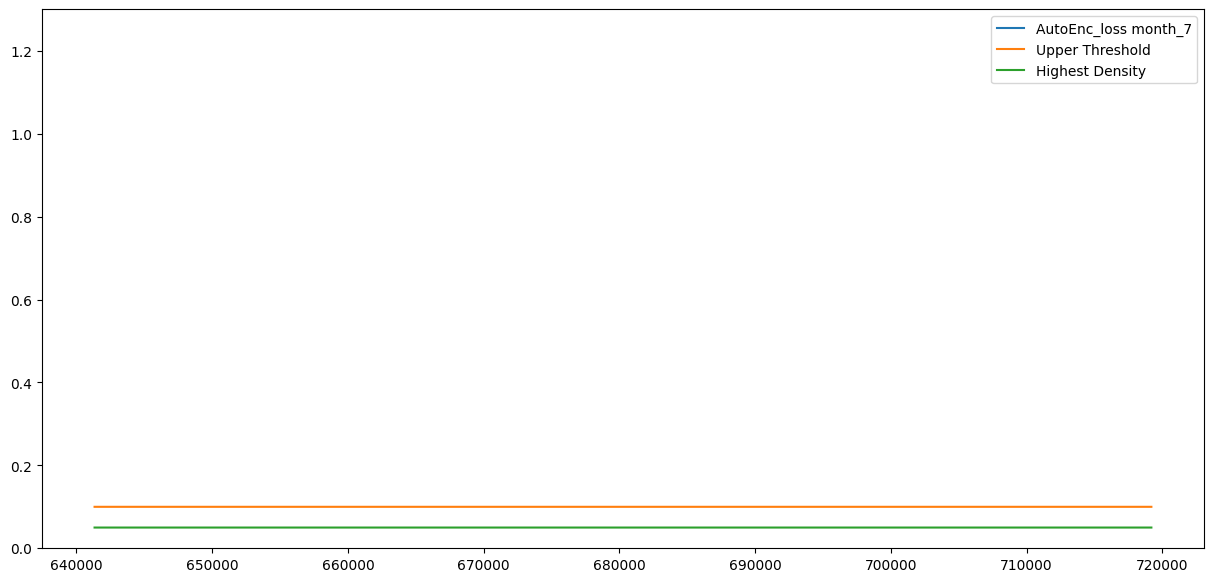

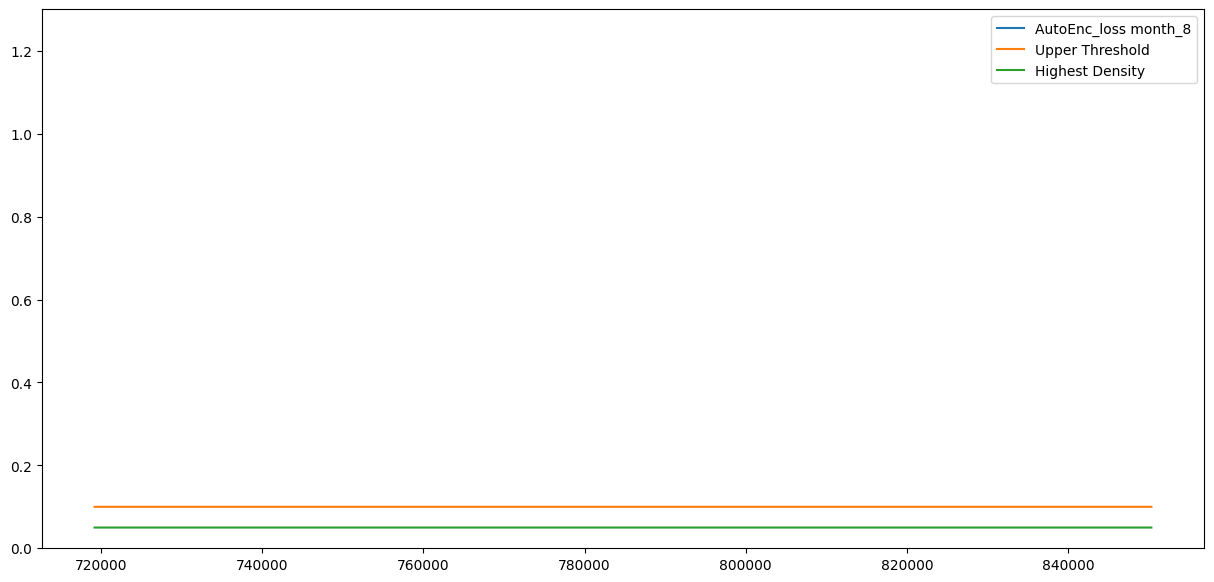

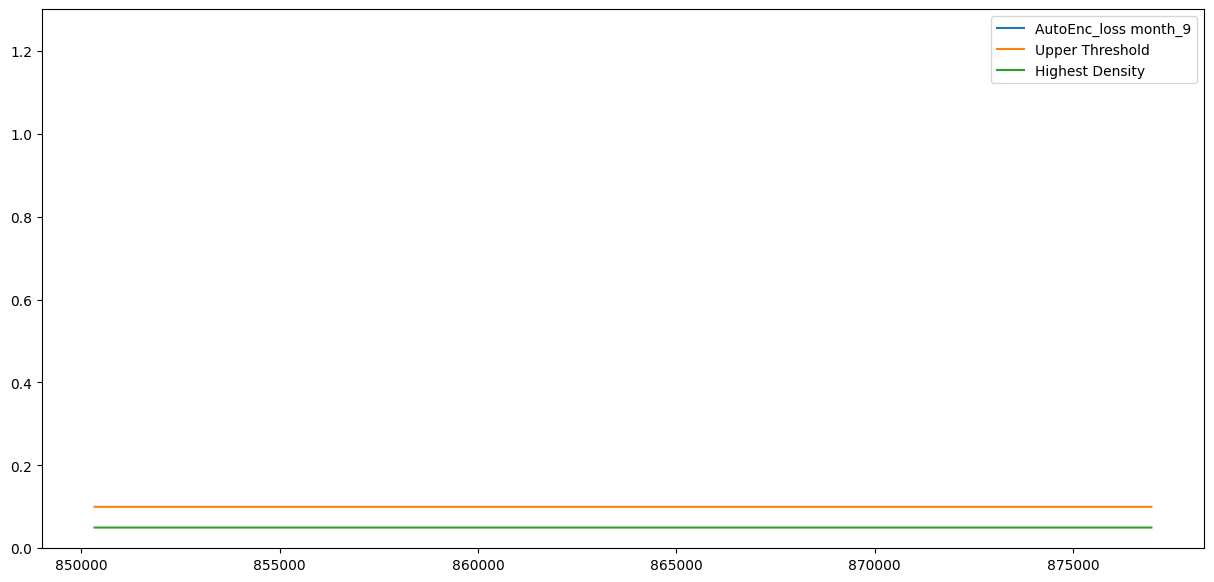

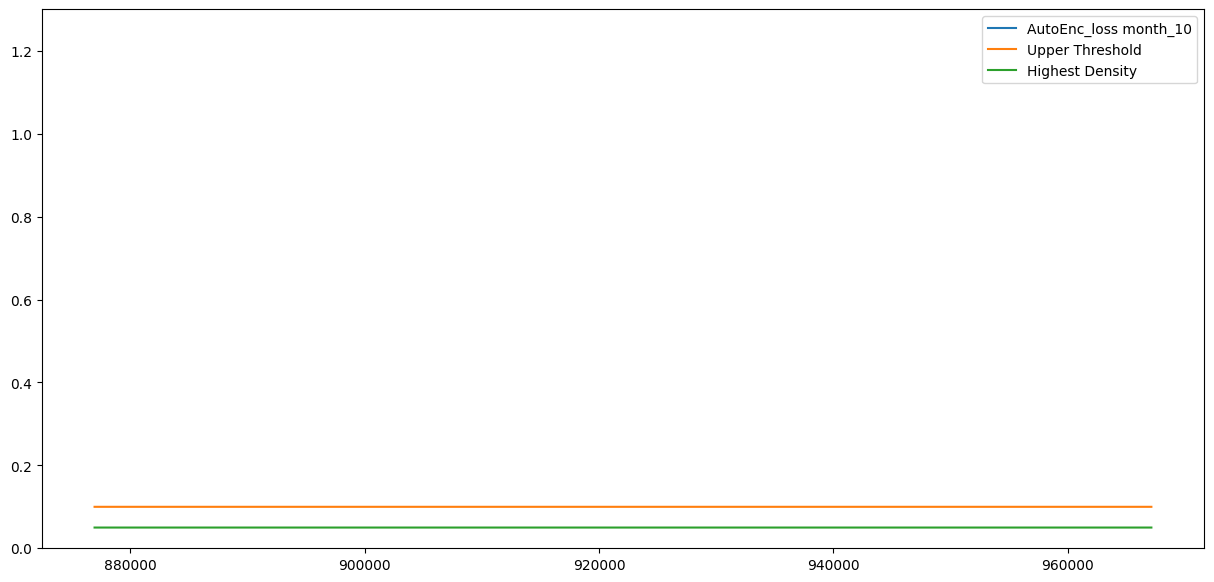

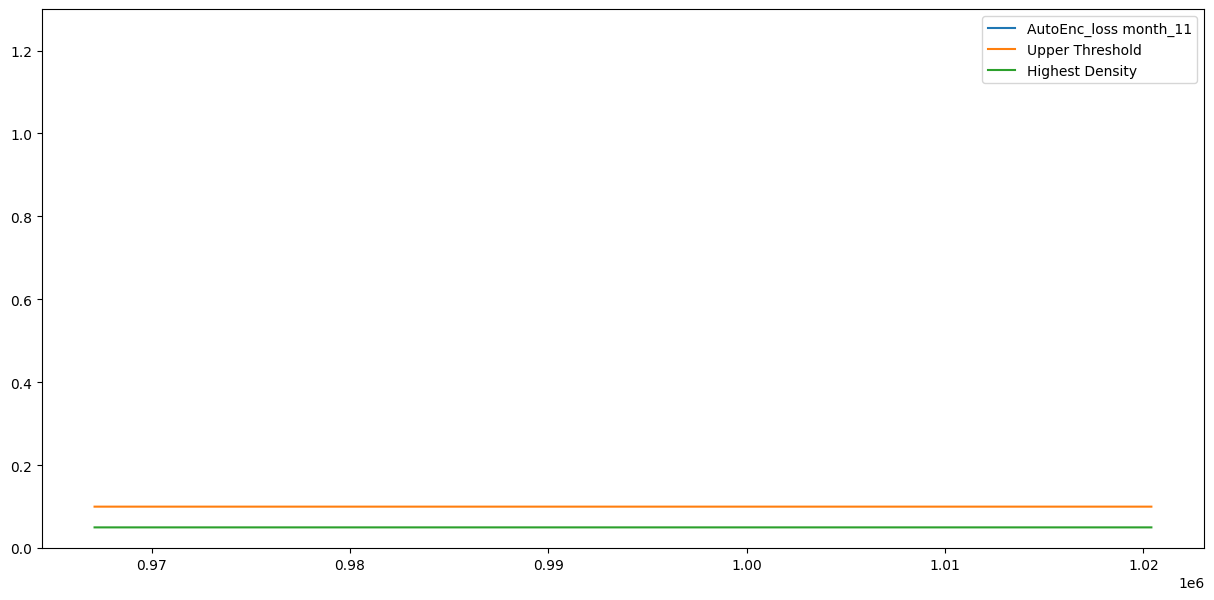

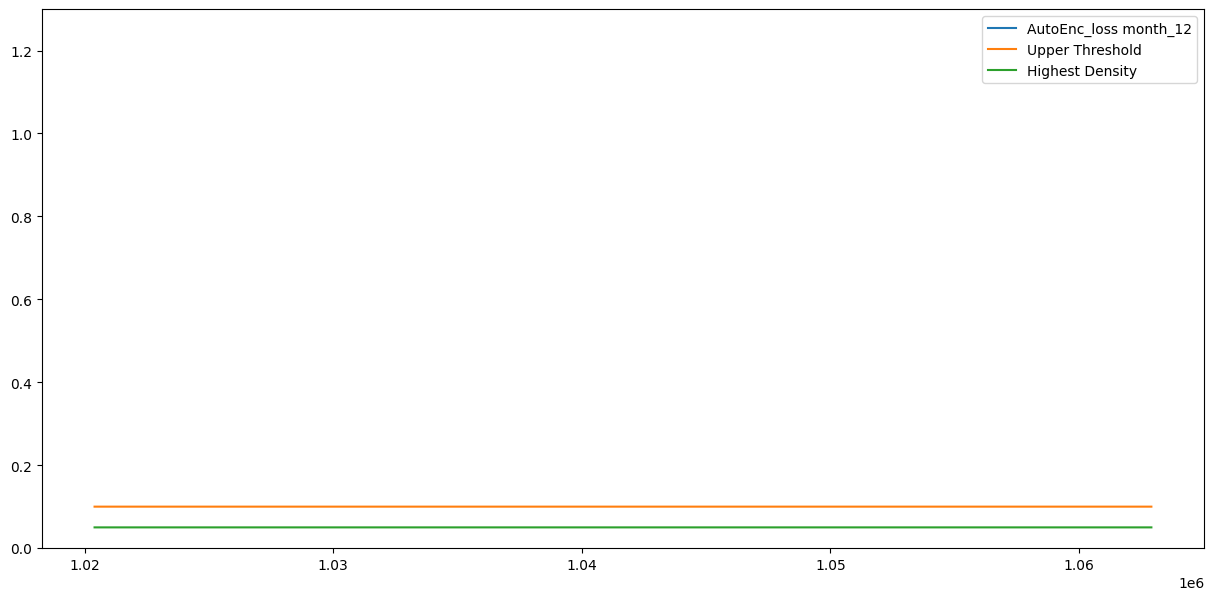

In [36]:
enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['AutoEnc_loss'] = enc_loss['Loss_mae']

main_df = pd.read_csv('/content/One_year_compiled.csv')



#Passing encoder loss to main dataframe, to make it easier to separate by month
main_df['AutoEnc_loss'] = corr['AutoEnc_loss']

#Getting list of months
months = main_df['month'].dropna().unique()

#Looping through every month
for month in months:
    #Grabbing the slice of the dataframe for each month
    month_df = main_df.groupby('month').get_group(month)


    # Array Thresholds
    upper_threshold = np.full((month_df['AutoEnc_loss'].size, 1), 0.1)
    high_density_threshold = np.full((month_df['AutoEnc_loss'].size, 1), 0.05)

    #Plot
    plt.subplots(figsize=(15,7))
    plt.plot(month_df.index, month_df['AutoEnc_loss'], label=f'AutoEnc_loss month_{month}')
    plt.plot(month_df.index, upper_threshold, label = 'Upper Threshold')
    plt.plot(month_df.index, high_density_threshold, label = 'Highest Density')
    plt.legend(loc='upper right')
    plt.ylim(0,1.3)

    plt.show()



**Now we will see Loss distribution by month**

In [38]:
enc_loss = pd.read_csv('/content/AutoEncoder_loss.csv')

corr['AutoEnc_loss'] = enc_loss['Loss_mae']

main_df = pd.read_csv('/content/One_year_compiled.csv')


main_df['AutoEnc_loss'] = corr['AutoEnc_loss']


months = main_df['month'].dropna().unique()

for month in months:
    month_df = main_df.groupby('month').get_group(month)
    kurt = (month_df['AutoEnc_loss']).kurtosis()
    print(f'Month {month} kurtosis = {kurt}')

Month 1 kurtosis = -0.8683052505553683
Month 2 kurtosis = 10.389222045983754
Month 3 kurtosis = nan
Month 4 kurtosis = nan
Month 5 kurtosis = nan
Month 6 kurtosis = nan
Month 7 kurtosis = nan
Month 8 kurtosis = nan
Month 9 kurtosis = nan
Month 10 kurtosis = nan
Month 11 kurtosis = nan
Month 12 kurtosis = nan


In [27]:
main_df = pd.read_csv('/content/One_year_compiled.csv')
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X),
                              columns=X.columns,
                              index=X.index)



X = preprocessing.scale(X)


train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)

X_train = X[:train_size]

seed(10)

act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X.
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10:
NUM_EPOCHS=50
BATCH_SIZE=200

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE,
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3253 - val_loss: 0.0111
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0032 - val_loss: 0.0062
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.7153e-04 - val_loss: 0.0029
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2729e-04 - val_loss: 0.0026
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9781e-04 - val_loss: 0.0022
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.3131e-04 - val_loss: 0.0021
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.8789e-04 - val_loss: 0.0021
Epoch 9/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6218e-04 - val_loss: 0.0019
Epoch 10/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4472e-04 - val_loss: 0.0018
Epoch 11/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1.2975e-04 - val_loss: 0.0020
Epoch 12/50
718/718 ━━━━━━━━━━━